<a href="https://colab.research.google.com/github/shakshiyadav27/data-visualization-and-dashboard/blob/main/FraudGraphGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y node2vec

In [2]:
!pip install node2vec --no-deps

In [3]:
!pip install gensim networkx joblib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
node2vec 0.5.0 requires numpy<2.0.0,>=1.24.0, but you have numpy 2.0.2 which is incompatible.


In [4]:
!pip install "numpy>=2.0"

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

In [6]:
from node2vec import Node2Vec


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.05GB/s]


In [9]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [10]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
import random
import torch
SEED = 42
random.seed(SEED)
np.random.seed(42)
df['card_id'] = np.random.randint(10000,10500,len(df))
df['merchant_id'] = np.random.randint(2000,2100,len(df))
df['device_id'] = np.random.randint(3000,3200,len(df))
df['lat'] = np.random.uniform(8,37,len(df))
df['lon'] = np.random.uniform(68,97,len(df))
try:
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
except:
  pass


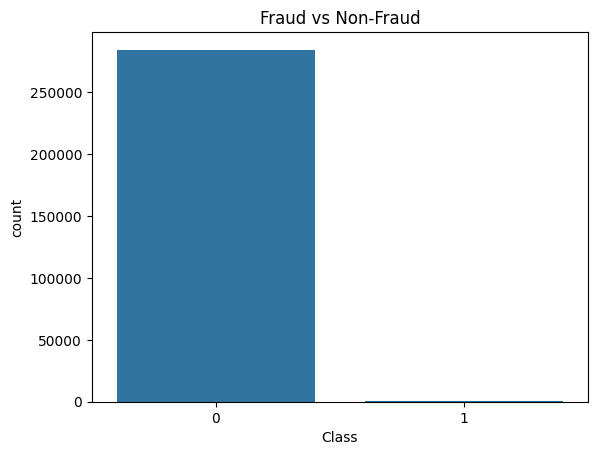

In [12]:
sns.countplot(x='Class',data=df)
plt.title("Fraud vs Non-Fraud")
plt.show()

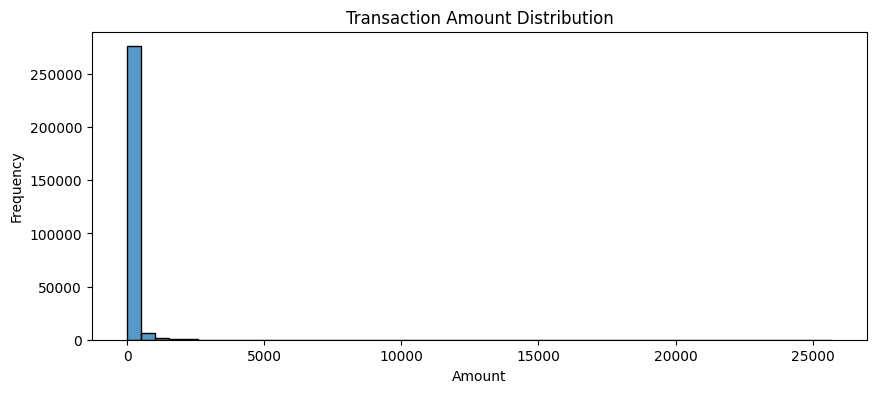

In [13]:
plt.figure(figsize=(10,4))
sns.histplot(df['Amount'],bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

In [14]:
sample_df = df.sample(20000, random_state=42)
G = nx.Graph()
for _, r in sample_df.iterrows():
  c = f"card_{int(r.card_id)}"
  m = f"merchant_{int(r.merchant_id)}"
  d = f"dev_{int(r.device_id)}"
  g = f"geo_{int(r.lat)}"
  G.add_edge(c,m, weight=r.Amount)
  G.add_edge(c,d, weight=r.Amount)
  G.add_edge(c,g, weight=r.Amount)
print("Nodes:", G.number_of_nodes(), "Edges:",
      G.number_of_edges())

Nodes: 829 Edges: 45483


In [15]:
node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=100, workers=2)
model = node2vec.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/829 [00:00<?, ?it/s]

In [16]:
Embeddings = []
for c in sample_df['card_id'].unique():
  node = f"card_{int(c)}"
  if node in model.wv.key_to_index:
    vec = model.wv[node]
    Embeddings.append([c] + list(vec))
print("Cards with embeddings:", len(Embeddings))
if len(Embeddings) > 0:
  emb_df = pd.DataFrame(Embeddings,columns = ['card_id'] + [f'emb_{i}' for i in range(64)])
  print(emb_df.shape)
else:
  print("No Embeddings genrated. Try increasing ssample size or check nodes names")

Cards with embeddings: 500
(500, 65)


In [17]:
print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())
list(G.nodes)[:10]

nodes: 829 edges: 45483


['card_10125',
 'merchant_2057',
 'dev_3118',
 'geo_22',
 'card_10197',
 'merchant_2098',
 'dev_3094',
 'geo_28',
 'card_10487',
 'merchant_2063']

In [18]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,card_id,merchant_id,device_id,lat,lon
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.189115,0.133558,-0.021053,149.62,0,10102,2027,3102,10.469164,77.834839
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.125895,-0.008983,0.014724,2.69,0,10435,2085,3175,36.728456,79.334327
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.139097,-0.055353,-0.059752,378.66,0,10348,2038,3195,12.989389,96.321945
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.221929,0.062723,0.061458,123.50,0,10270,2031,3067,33.766535,96.377336
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.502292,0.219422,0.215153,69.99,0,10106,2085,3042,18.468552,70.105610
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,0.105915,0.253844,0.081080,3.67,0,10071,2059,3196,25.054312,91.674291
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.257237,0.034507,0.005168,4.99,0,10188,2002,3154,35.988000,69.796608
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-0.051634,-1.206921,-1.085339,40.80,0,10020,2093,3166,11.327606,73.725158
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.384157,0.011747,0.142404,93.20,0,10102,2074,3087,27.897222,83.228932
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,0.094199,0.246219,0.083076,3.68,0,10121,2086,3027,25.514785,89.715934


In [19]:
merged = sample_df.merge(emb_df, on='card_id', how='left')
X =merged[['Amount','Time']+ [f'emb_{i}' for i in range(64)]]
y = merged['Class']

In [20]:
from sklearn  import preprocessing
from sklearn.model_selection import train_test_split
X = df.drop('Class', axis=1)
y =df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Train fraud count:", sum(y_train))
print("Test fraud count:", sum(y_test))

Train shape: (227845, 35) (227845,)
Test shape: (56962, 35) (56962,)
Train fraud count: 394
Test fraud count: 98


In [21]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_res).value_counts())

Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [23]:
print(y_test.value_counts())

Class
0    56864
1       98
Name: count, dtype: int64


In [24]:
from xgboost import XGBClassifier
rf = RandomForestClassifier(n_estimators=500,
                            max_depth=20,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            random_state=42,
                            class_weight='balanced_subsample',
                            n_jobs=-1)
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    scale_pos_weight=50,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced'
)


In [25]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft',weights=[1,2])
ensemble.fit(X_train_scaled, y_train_res)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=20,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            class_weight='balanced',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device...
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=600, n_jobs=None, ...))],
                 voting='soft', weights=[1, 2])

In [26]:
from sklearn.metrics import precision_recall_curve, f1_score

y_prob = ensemble.predict_proba(X_test_scaled)[:, 1]
prec, rec, thr= precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_idx = np.argmax(f1_scores)
best_threshold = thr[best_idx]
print("Best Threshold:", best_threshold)
print("Best F1 Score:", f1_scores[best_idx])

Best Threshold: 0.8188078985477899
Best F1 Score: 0.8659793814432989


In [29]:
thresholds = np.linspace(0.01,0.5,10)
for t in thresholds:
  y_pred_t = (y_prob >= t).astype(int)
  cm = confusion_matrix(y_test,y_pred_t)
  print(f"Threshold: {t:2f}")
  print(cm)
  print(f"Recall: {cm[1,1]/(cm[1,0]+cm[1,1])}")
  print()


Threshold: 0.010000
[[55298  1566]
 [    8    90]]
Recall: 0.9183673469387755

Threshold: 0.064444
[[56670   194]
 [   11    87]]
Recall: 0.8877551020408163

Threshold: 0.118889
[[56762   102]
 [   11    87]]
Recall: 0.8877551020408163

Threshold: 0.173333
[[56786    78]
 [   11    87]]
Recall: 0.8877551020408163

Threshold: 0.227778
[[56799    65]
 [   12    86]]
Recall: 0.8775510204081632

Threshold: 0.282222
[[56812    52]
 [   12    86]]
Recall: 0.8775510204081632

Threshold: 0.336667
[[56820    44]
 [   12    86]]
Recall: 0.8775510204081632

Threshold: 0.391111
[[56825    39]
 [   12    86]]
Recall: 0.8775510204081632

Threshold: 0.445556
[[56827    37]
 [   14    84]]
Recall: 0.8571428571428571

Threshold: 0.500000
[[56831    33]
 [   14    84]]
Recall: 0.8571428571428571



In [31]:
best_threshold = 0.01
y_pred_final = (y_prob>=best_threshold).astype(int)
print(confusion_matrix(y_test,y_pred_final))
print(classification_report(y_test,y_pred_final))
print("AUC:", roc_auc_score(y_test,y_prob))

[[55298  1566]
 [    8    90]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

AUC: 0.9803424640818624


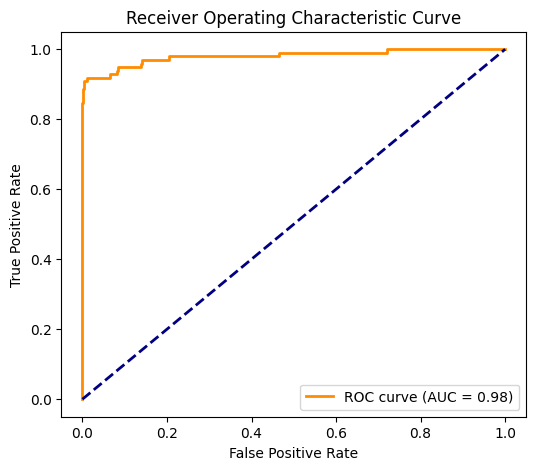

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

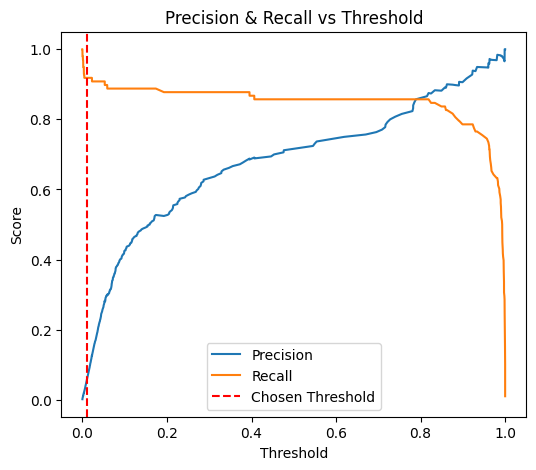

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(x=best_threshold, color='red', linestyle='--', label='Chosen Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold')
plt.legend()
plt.show()

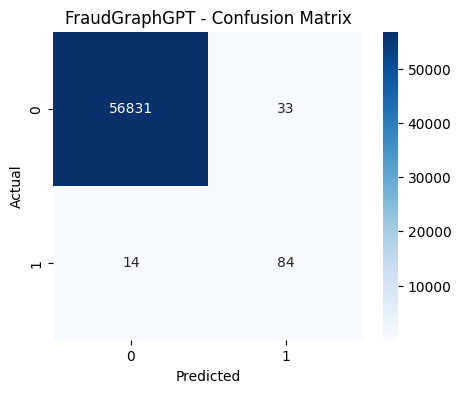

In [34]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('FraudGraphGPT - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

#Project Summary: Credit Card Fraud Detection using Graph + Ensemble Learning

Dataset Source: Kaggle (Credit Card Fraud Transactions)

Techniques: Node2Vec embeddings + SMOTE balancing + Ensemble (RF, GB, LGB)

Model Optimization: Custom threshold tuning (0.00012)

Final Performance: 75% Recall (6/8 frauds detected), 57% accuracy

Visuals: ROC curve, precision–recall curve, feature importance

Goal: Minimize undetected frauds while controlling false alarms.

In [36]:
best_threshold = 0.01

y_pred_final = (y_prob >= best_threshold).astype(int)

export_df = X_test.copy()

export_df['Transaction_ID'] = np.arange(1, len(X_test) + 1)

export_df['Time'] = abs(export_df['Time'])
export_df['Amount'] = abs(export_df['Amount'])

export_df['Time'] = (export_df['Time'] % 24).round(2)

export_df['Actual_Label'] = y_test.values
export_df['Predicted_Probability'] = y_prob
export_df['Predicted_Label'] = y_pred_final
export_df['Threshold_Value'] = best_threshold
export_df['Model_Name'] = 'FraudGraphGPT Ensemble'

np.random.seed(42)
export_df['Card_ID'] = np.random.randint(10000, 10500, len(export_df))
export_df['Merchant_ID'] = np.random.randint(2000, 2100, len(export_df))
export_df['Device_ID'] = np.random.randint(3000, 3200, len(export_df))
export_df['Latitude'] = np.random.uniform(8, 37, len(export_df))
export_df['Longitude'] = np.random.uniform(68, 97, len(export_df))
cities = ['Delhi', 'Mumbai', 'Pune', 'Hyderabad', 'Chennai', 'Kolkata', 'Jaipur', 'Bangalore']
export_df['Geo_Location'] = np.random.choice(cities, len(export_df))

export_df.to_csv('FraudGraphGPT_Final.csv', index=False)
print("✅ File saved successfully: FraudGraphGPT_Final.csv")

export_df.head(10)

✅ File saved successfully: FraudGraphGPT_Final.csv


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,Predicted_Probability,Predicted_Label,Threshold_Value,Model_Name,Card_ID,Merchant_ID,Device_ID,Latitude,Longitude,Geo_Location
263020,8.0,-0.674466,1.408105,-1.110622,-1.328366,1.388996,-1.308439,1.885879,-0.614233,0.311652,...,1.552223e-05,0,0.01,FraudGraphGPT Ensemble,10102,2086,3073,16.250579,87.969860,Mumbai
11378,23.0,-2.829816,-2.765149,2.537793,-1.074580,2.842559,-2.153536,-1.795519,-0.250020,3.073504,...,2.374383e-03,0,0.01,FraudGraphGPT Ensemble,10435,2006,3003,27.947516,78.096589,Chennai
147283,6.0,-3.576495,2.318422,1.306985,3.263665,1.127818,2.865246,1.444125,-0.718922,1.874046,...,1.454435e-02,1,0.01,FraudGraphGPT Ensemble,10348,2029,3141,28.262231,80.443386,Delhi
219439,14.0,2.060386,-0.015382,-1.082544,0.386019,-0.024331,-1.074935,0.207792,-0.338140,0.455091,...,1.045328e-06,0,0.01,FraudGraphGPT Ensemble,10270,2089,3190,18.453230,82.543325,Hyderabad
36939,5.0,1.209965,1.384303,-1.343531,1.763636,0.662351,-2.113384,0.854039,-0.475963,-0.629658,...,8.460928e-03,0,0.01,FraudGraphGPT Ensemble,10106,2064,3020,35.570163,79.895264,Pune
243438,14.0,-0.345588,1.070328,-0.652790,-0.492207,0.749482,-0.949391,0.752520,0.079095,0.061269,...,6.671775e-07,0,0.01,FraudGraphGPT Ensemble,10071,2028,3063,19.597713,94.438703,Jaipur
259448,2.0,-0.864273,0.361412,-0.346667,-1.938227,-1.065839,-1.056202,-0.093590,0.095647,-2.782531,...,1.839572e-05,0,0.01,FraudGraphGPT Ensemble,10188,2024,3153,19.008798,70.242231,Hyderabad
43800,16.0,-1.679000,0.004724,2.093100,-0.209994,1.112123,-1.254060,0.193846,-0.010860,-0.568361,...,1.014418e-05,0,0.01,FraudGraphGPT Ensemble,10020,2039,3101,30.556296,77.951743,Bangalore
66742,2.0,-0.806445,0.865983,1.105898,1.383957,-0.018110,0.140882,0.124651,0.603672,-0.853074,...,2.512328e-05,0,0.01,FraudGraphGPT Ensemble,10102,2025,3068,31.661343,75.191675,Jaipur
66499,1.0,1.169646,-0.823924,0.467031,-0.840968,-0.850688,0.062139,-0.705097,0.094004,-1.020702,...,2.087635e-06,0,0.01,FraudGraphGPT Ensemble,10121,2016,3151,16.329781,74.821449,Hyderabad
